In [1]:
from autoemulate.emulators import GaussianProcess
from autoemulate.simulations.projectile import simulate_projectile
from autoemulate.experimental_design import LatinHypercube
from dataclasses import dataclass, field
import tqdm, numpy as np, matplotlib.pyplot as plt
from typing import Tuple, List
from abc import ABC, abstractmethod
from scipy.spatial.distance import cdist

# Active Learning (AL)

In AutoEmulate, we use inexpensive emulator models to approximate costly simulations. However, these emulators require training data, which is often expensive to generate. Therefore, a critical challenge is deciding which input points to query from the simulator to optimize the emulator's performance while minimizing simulation costs.

Active learning strategies can be categorized into three main types:
1. Pool-based: We have access to a large pool of unlabeled data and must decide which data points to label.
2. Membership-based (Query Synthesis): We can generate new input queries based on prior knowledge of the domain (e.g., uniform sampling).
3. Stream-based: Unlabeled data arrives sequentially, and we must decide in real time whether to label each point.

To formalise, we have the following API for an active learning.

In [2]:
class Simulator(ABC):
    @abstractmethod
    def __call__(self, X: np.ndarray) -> np.ndarray:
        pass

class Emulator:
    @abstractmethod
    def __call__(self, X: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        pass
    @abstractmethod
    def fit(self, X: np.ndarray, Y: np.ndarray):
        pass
    
@dataclass(kw_only=True)
class Learner:
    simulator: Simulator
    emulator: Emulator
    X_train: np.ndarray # (n, a) array of inputs
    Y_train: np.ndarray # (n, b) array of outputs
    
    def __post_init__(self):
        self.emulator.fit(self.X_train, self.Y_train)

## Stream-based AL

In this notebook, we will focus on stream-based active learning, where data arrives one sample at a time. Given this setup, a stream-based active learner should implement a method `query(x) -> bool`. This method takes in a sample `x` and determines whether it should be labeled. We implement the following query strategies:
1. Random Sampling: we choose to query an input with some constant probability.
2. Threshold Sampling: we choose to query an input if the emulator's prediction uncertainty is above a certain threshold.
3. PID STD: same as (2), but we dynamically adjust the threshold such that a certain query rate is achieved.
4. Diversity Sampling: we choose to query an input if its minimum distance to the training set is above a certain threshold.
5. PID Diversity: same as (4), but we dynamically adjust the threshold such that a certain query rate is achieved.

In [42]:
@dataclass(kw_only=True)
class Stream_Based(Learner):
    stds: list = field(init=False, default_factory=list)
    queries: list = field(init=False, default_factory=list)

    def __call__(self, x: np.ndarray):
        if self.query(x):
            self.update(x)

    @abstractmethod
    def query(self, x: np.ndarray) -> bool:
        # This should also record to the lists
        pass

    def update(self, x):
        x = x.reshape(1, -1)
        y = self.simulator(x)
        self.X_train = np.concatenate([self.X_train, x])
        self.Y_train = np.concatenate([self.Y_train, y])
        self.emulator.fit(self.X_train, self.Y_train)

    @property
    def rates(self) -> List[float]:
        rates = np.cumsum(self.queries) / np.arange(1, len(self.queries) + 1)
        return rates.tolist()
        

In [43]:
@dataclass(kw_only=True)
class Random(Stream_Based):
    p_query: float

    def query(self, x):
        std = self.emulator(x.reshape(1, -1))[1].item()
        query = np.random.random() < self.p_query
        self.stds.append(std)
        self.queries.append(query)
        return query

In [44]:
@dataclass(kw_only=True)
class Threshold(Stream_Based):
    threshold: float

    def query(self, x):
        std = self.emulator(x.reshape(1, -1))[1].item()
        query = std >= self.threshold
        self.stds.append(std)
        self.queries.append(query)
        return query

In [45]:
@dataclass(kw_only=True)
class PID_STD(Threshold):
    thresholds: list = field(init=False, default_factory=list)
    errors: list = field(init=False, default_factory=list)
    max_threshold: float
    target_rate: float
    Kp: float
    Kd: float
    Ki: float

    def query(self, x):
        query = super().query(x) # Records std and query
        self.thresholds.append(self.threshold)
        self.errors.append(self.rates[-1] - self.target_rate)
        ep = self.errors[-1]
        ed = self.errors[-1] - self.errors[-2] if len(self.errors) > 1 else 0.0
        ei = np.sum(self.errors)
        self.threshold += self.Kp * ep + self.Kd * ed + self.Ki * ei
        self.threshold = np.clip(self.threshold, 1e-6, self.max_threshold)
        return query

In [46]:
@dataclass(kw_only=True)
class Diveristy(Stream_Based):
    distances: list = field(init=False, default_factory=list)
    threshold: float
    
    def query(self, x):
        # d = np.min([np.linalg.norm(x - x_train) for x_train in self.X_train])
        d = np.min(cdist(self.X_train, x.reshape(1, -1)))
        query = d >= self.threshold
        std = self.emulator(x.reshape(1, -1))[1].item()
        self.stds.append(std)
        self.queries.append(query)
        self.distances.append(d)
        return query

In [47]:
@dataclass(kw_only=True)
class PID_Diversity(Diveristy):
    thresholds: list = field(init=False, default_factory=list)
    errors: list = field(init=False, default_factory=list)
    max_threshold: float
    target_rate: float
    Kp: float
    Kd: float
    Ki: float

    def query(self, x):
        query = super().query(x) # Records std and query
        self.thresholds.append(self.threshold)
        self.errors.append(self.rates[-1] - self.target_rate)
        ep = self.errors[-1]
        ed = self.errors[-1] - self.errors[-2] if len(self.errors) > 1 else 0.0
        ei = np.sum(self.errors)
        self.threshold += self.Kp * ep + self.Kd * ed + self.Ki * ei
        self.threshold = np.clip(self.threshold, 1e-6, self.max_threshold)
        return query

## An example of stream-based AL
Here we test all of the above querying methods on a simple regression of a sinusoid. Note that make use of the outlined API above for `Simulator` and `Emulator`.

In [12]:
class Sin(Simulator):
    def __call__(self, X):
        return np.sin(X)
    
class GP(Emulator):
    def __init__(self):
        self.model = GaussianProcess()
    def fit(self, X, Y):
        self.model.fit(X, Y)
    def __call__(self, X):
        return self.model.predict(X, return_std=True)

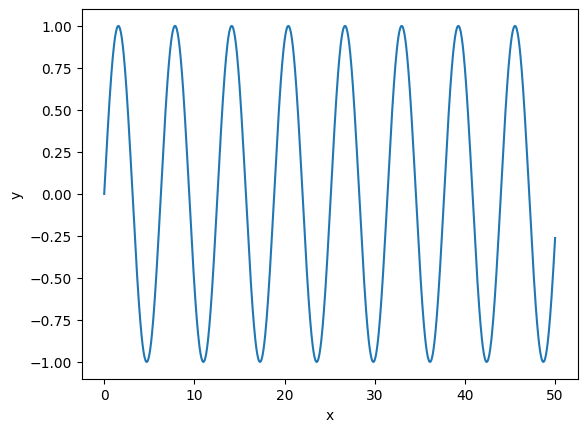

In [49]:
simulator = Sin()
X_test = np.linspace(0, 50, 1000).reshape(-1, 1)
Y_test = simulator(X_test)
plt.plot(X_test.reshape(-1), Y_test.reshape(-1))
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Now we instantiate all of the different learner, each with its own Gaussian process emulator.

**Adjust the values to see different behaviour!**

In [50]:
# Simulator
X_train = LatinHypercube([(0, 50)]).sample(10)
Y_train = simulator(X_train)

# Emulators and learners
random_learner = Random(
    simulator=simulator, emulator=GP(), 
    X_train=X_train, Y_train=Y_train, p_query=0.1
)
threshold_learner = Threshold(
    simulator=simulator, emulator=GP(), 
    X_train=X_train, Y_train=Y_train, threshold=0.2
)
pid_std_learner = PID_STD(
    simulator=simulator, emulator=GP(), 
    X_train=X_train, Y_train=Y_train, 
    threshold=0.2, target_rate=0.1,
    Kp=1.0, Kd=2.0, Ki=0.0, max_threshold=0.2
)
diversity_learner = Diveristy(
    simulator=simulator, emulator=GP(),
    X_train=X_train, Y_train=Y_train, threshold=1.0
)
pid_diversity_learner = PID_Diversity(
    simulator=simulator, emulator=GP(),
    X_train=X_train, Y_train=Y_train,
    threshold=5.0, target_rate=0.1,
    Kp=2.0, Kd=3.0, Ki=0.0, max_threshold=5.0
)


Now we will run a stream-based AL loop where we simulate incoming queries to the learner. Notice how the rate of the `PID` methods stabalizes!

In [51]:
# Active learning loop
inputs = LatinHypercube([(0, 50)]).sample(500)
for learner in (learners := [random_learner, threshold_learner, pid_std_learner, diversity_learner, pid_diversity_learner]):
    for x in (pb := tqdm.tqdm(inputs)):
        learner(x)
        pb.set_description(f'{learner.__class__.__name__} | Std = {learner.stds[-1]:.4f} | Rate = {learner.rates[-1]:.4f}')

Random | Std = 0.0238 | Rate = 0.1000: 100%|██████████| 500/500 [00:06<00:00, 72.18it/s] 
Threshold | Std = 0.1382 | Rate = 0.0480: 100%|██████████| 500/500 [00:03<00:00, 134.17it/s]
PID_STD | Std = 0.0169 | Rate = 0.1020: 100%|██████████| 500/500 [00:06<00:00, 73.09it/s] 
Diveristy | Std = 0.0294 | Rate = 0.0520: 100%|██████████| 500/500 [00:03<00:00, 140.91it/s]
PID_Diversity | Std = 0.0163 | Rate = 0.0860: 100%|██████████| 500/500 [00:05<00:00, 93.08it/s] 


Now we can compare how the emulators' uncertainties of each query decreases over iterations. Note that we apply some smoothing to make it easier to see.

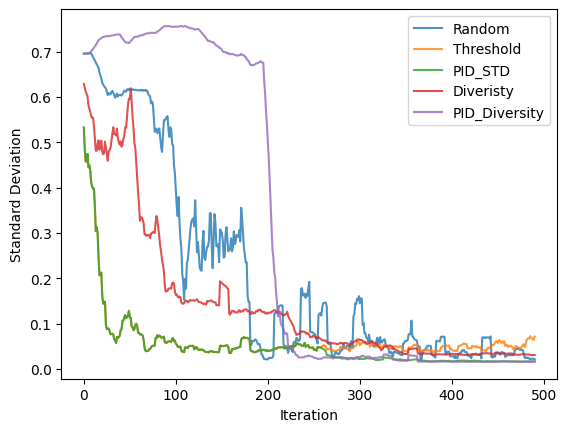

In [56]:
window = 10
for learner in learners:
    plt.plot(
        np.convolve(learner.stds, np.ones(window) / window, mode='valid'),
        # learner.stds,
        label=learner.__class__.__name__, 
        alpha=0.8
    )
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Standard Deviation')
plt.show()

We also plot the query rate over iterations. Note that the PID ones stabalize to their corresponding targets (where we put a dashed line).

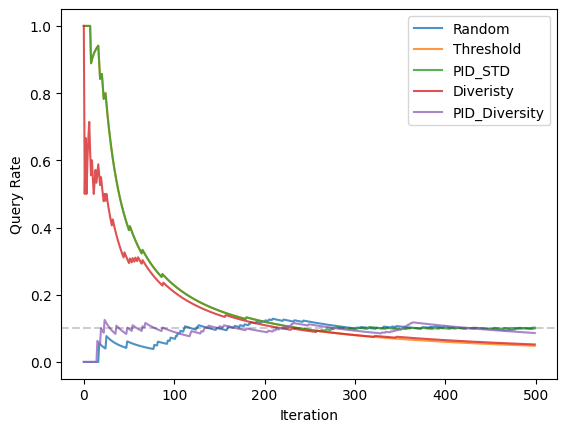

In [58]:
for learner in learners:
    plt.plot(learner.rates, label=learner.__class__.__name__, alpha=0.8)
plt.axhline(y=0.1, color="k", linestyle="--", alpha=0.2)
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Query Rate')
plt.show()

We can also take a look at how the control parameter (the threshold) of the PID methods changes over iterations.
1. As we can see, the threshold of the regular STD threshold learner stays constant.
2. The threshold of the PID STD learner is upper bounded by a desired max Std., but then eventually it optimized for achieving a certain query rate.

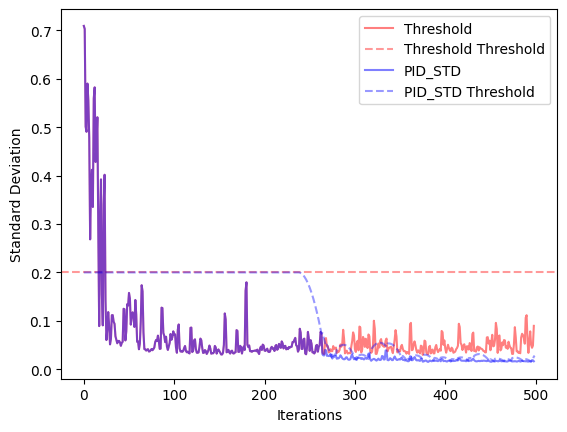

In [87]:
window = 2
plt.plot(np.convolve(threshold_learner.stds, np.ones(window) / window, mode='valid'), color='r', alpha=0.5, label=threshold_learner.__class__.__name__)
plt.axhline(y=threshold_learner.threshold, color="r", linestyle="--", alpha=0.4, label=f'{threshold_learner.__class__.__name__} Threshold')
plt.plot(np.convolve(pid_std_learner.stds, np.ones(window) / window, mode='valid'), color='b', alpha=0.5, label=pid_std_learner.__class__.__name__)
plt.plot(pid_std_learner.thresholds, color='b', alpha=0.4, linestyle='--', label=f'{pid_std_learner.__class__.__name__} Threshold')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Standard Deviation')
plt.show()

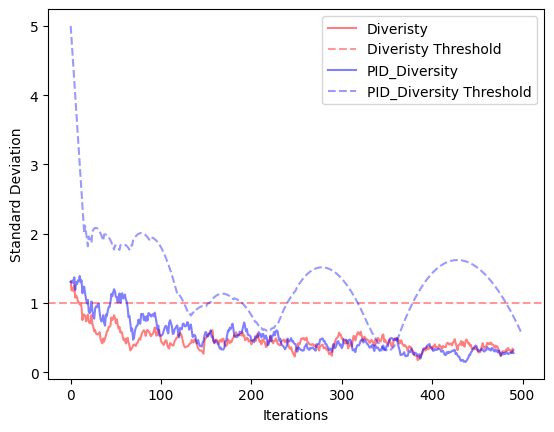

In [96]:
window = 10
plt.plot(np.convolve(diversity_learner.distances, np.ones(window) / window, mode='valid'), color='r', alpha=0.5, label=diversity_learner.__class__.__name__)
plt.axhline(y=diversity_learner.threshold, color="r", linestyle="--", alpha=0.4, label=f'{diversity_learner.__class__.__name__} Threshold')
plt.plot(np.convolve(pid_diversity_learner.distances, np.ones(window) / window, mode='valid'), color='b', alpha=0.5, label=pid_diversity_learner.__class__.__name__)
plt.plot(pid_diversity_learner.thresholds, color='b', alpha=0.4, linestyle='--', label=f'{pid_diversity_learner.__class__.__name__} Threshold')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Standard Deviation')
plt.show()